# **AI-based Stress Level Prediction from Digital Device Usage**

In [26]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from google.colab import files
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import chi2, mutual_info_classif
from sklearn.decomposition import PCA


# **Missing value , duplicate handling**

Missing values per column:
user_id                             0
age                                 0
gender                              0
daily_screen_time_hours             0
phone_usage_hours                   0
laptop_usage_hours                  0
tablet_usage_hours                  0
tv_usage_hours                      0
social_media_hours                  0
work_related_hours                  0
entertainment_hours                 0
gaming_hours                        0
sleep_duration_hours                0
sleep_quality                       0
mood_rating                         0
stress_level                        0
physical_activity_hours_per_week    0
location_type                       0
mental_health_score                 0
uses_wellness_apps                  0
eats_healthy                        0
caffeine_intake_mg_per_day          0
weekly_anxiety_score                0
weekly_depression_score             0
mindfulness_minutes_per_day         0
dtype: int64

Missing v

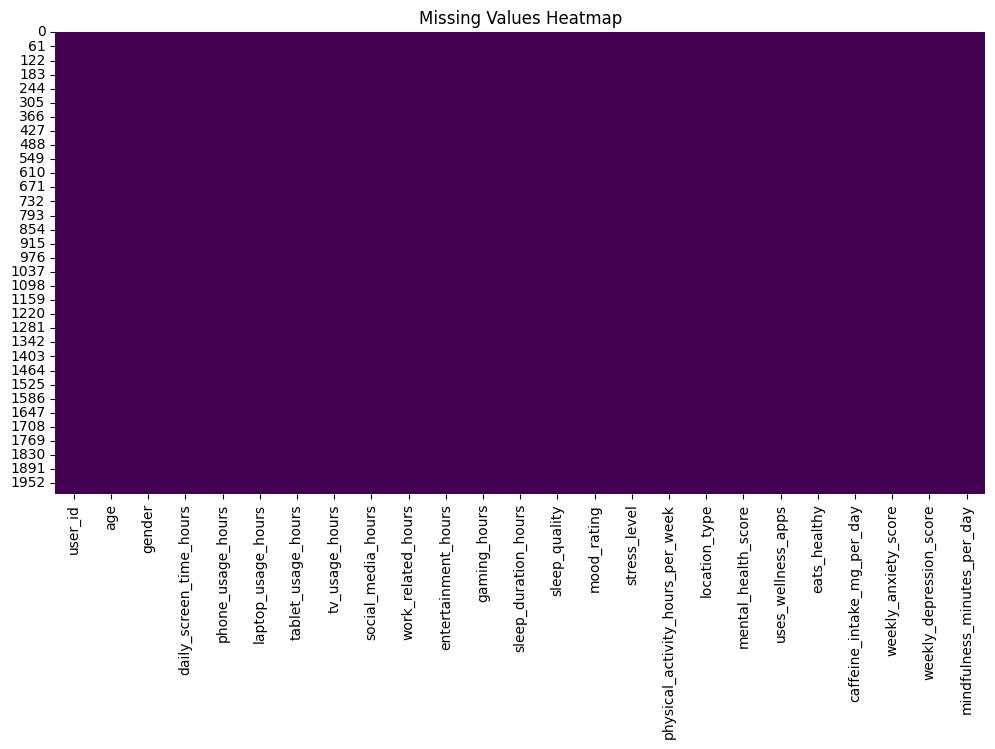

In [27]:
df = pd.read_csv('digital_diet_mental_health.csv')

#Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

#Impute missing values (assuming some exist; in this dataset, it might be clean)
# Numerical: Use median for skewed data
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
for col in numerical_cols:
    if df[col].isnull().any():
        df[col].fillna(df[col].median(), inplace=True)

# Categorical: Use mode
categorical_cols = ['gender', 'location_type']
for col in categorical_cols:
    if df[col].isnull().any():
        df[col].fillna(df[col].mode()[0], inplace=True)

#Verify no missing values left
print("\nMissing values after imputation:")
print(df.isnull().sum())

plt.figure(figsize=(12,6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()


# Save processed data if needed
df.to_csv('processed_missing.csv', index=False)

In [ ]:
#no missing values

In [28]:
#Duplicate handaling

# Count total duplicate rows
duplicates = df.duplicated().sum()
print("Total duplicate rows:", duplicates)

Total duplicate rows: 0


# **Encoding**

Unique values in categorical columns:
gender: ['Female' 'Male' 'Other']
location_type: ['Urban' 'Suburban' 'Rural']

Data after encoding:
  user_id  age  daily_screen_time_hours  phone_usage_hours  \
0  user_1   51                      4.8                3.4   
1  user_2   64                      3.9                3.5   
2  user_3   41                     10.5                2.1   
3  user_4   27                      8.8                0.0   
4  user_5   55                      5.9                1.7   

   laptop_usage_hours  tablet_usage_hours  tv_usage_hours  social_media_hours  \
0                 1.3                 1.6             1.6                 4.1   
1                 1.8                 0.9             2.0                 2.7   
2                 2.6                 0.7             2.2                 3.0   
3                 0.0                 0.7             2.5                 3.3   
4                 1.1                 1.5             1.6                 1.1   

  

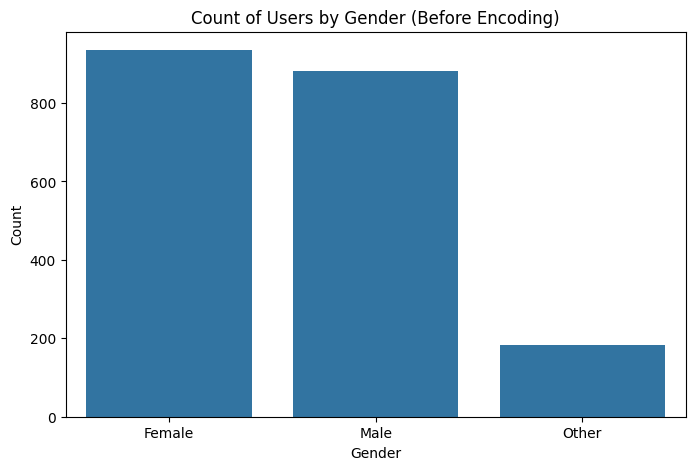

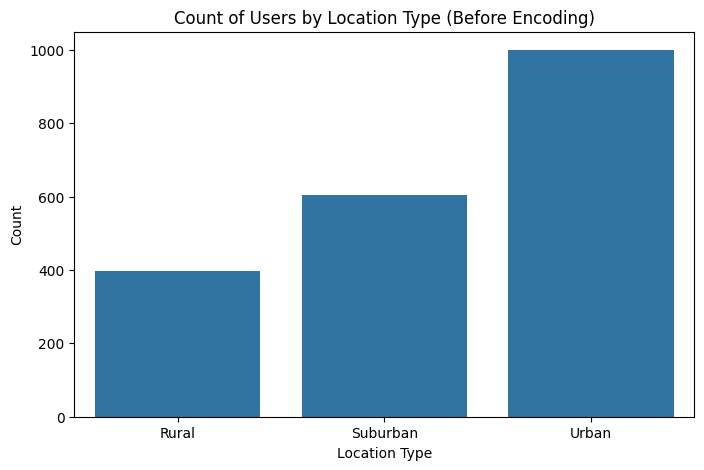

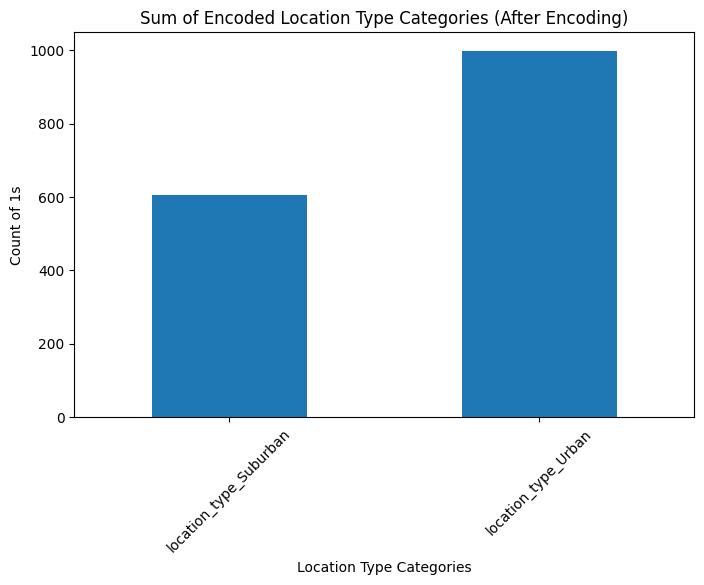

In [29]:



# Load data (assume from previous step or raw)
df = pd.read_csv('processed_missing.csv')  # Or 'processed_missing.csv'

# Step 1: Identify categorical columns and verify their values
categorical_cols = ['gender', 'location_type']
print("Unique values in categorical columns:")
for col in categorical_cols:
    unique_vals = df[col].unique()
    print(f"{col}: {unique_vals}")
    if col == 'location_type' and not all(x in unique_vals for x in ['Rural', 'Suburban', 'Urban']):
        print("Warning: Expected categories (Rural, Suburban, Urban) not all present in location_type.")

# Step 2: One-Hot Encoding
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Drop first to avoid multicollinearity
encoded = encoder.fit_transform(df[categorical_cols])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical_cols))

# Concatenate and drop originals
df_encoded = pd.concat([df.drop(categorical_cols, axis=1), encoded_df], axis=1)

# Step 3: Verify
print("\nData after encoding:")
print(df_encoded.head())
print("\nNote: The first category of each column (e.g., Rural for location_type if alphabetically first) is dropped as the reference and represented by 0s in the other columns.")

# Step 4: EDA Visualization - Countplot of gender (original)
plt.figure(figsize=(8, 5))
sns.countplot(x='gender', data=df)
plt.title('Count of Users by Gender (Before Encoding)')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

# Step 5: EDA Visualization - Countplot of location_type (original)
plt.figure(figsize=(8, 5))
sns.countplot(x='location_type', data=df, order=sorted(df['location_type'].dropna().unique()))
plt.title('Count of Users by Location Type (Before Encoding)')
plt.xlabel('Location Type')
plt.ylabel('Count')
plt.show()

# Step 6: EDA Visualization - Sum of encoded location_type columns
plt.figure(figsize=(8, 5))
loc_cols = [col for col in df_encoded.columns if col.startswith('location_type_')]
df_encoded[loc_cols].sum().plot(kind='bar')
plt.title('Sum of Encoded Location Type Categories (After Encoding)')
plt.xlabel('Location Type Categories')
plt.ylabel('Count of 1s')
plt.xticks(rotation=45)
plt.show()

# Interpretation: The first plot shows the distribution of gender categories. The second plot displays the distribution of location_type categories present in the data. The third plot shows the sum of 1s in the encoded location_type columns, where the dropped category (e.g., Rural) is represented by 0s in all other columns.

# Save processed data
df_encoded.to_csv('processed_encoding.csv', index=False)

# **Outliers handling**

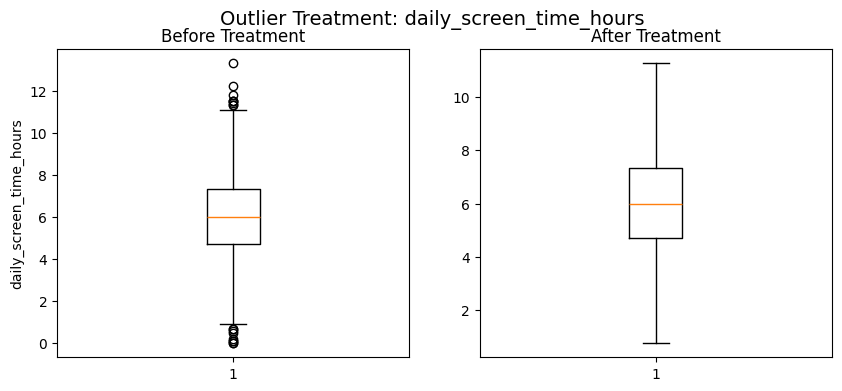

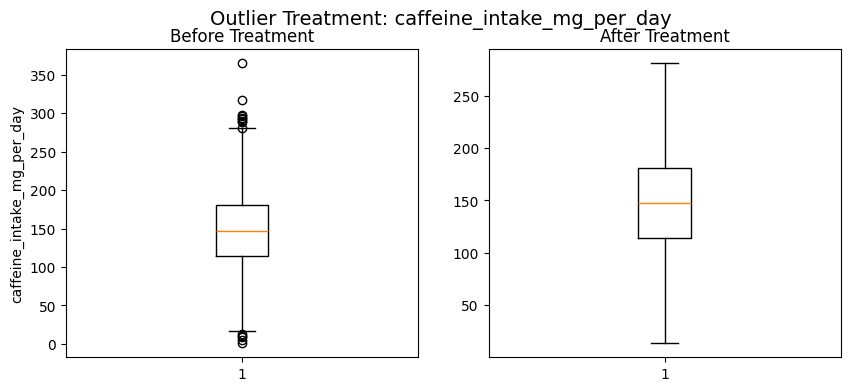

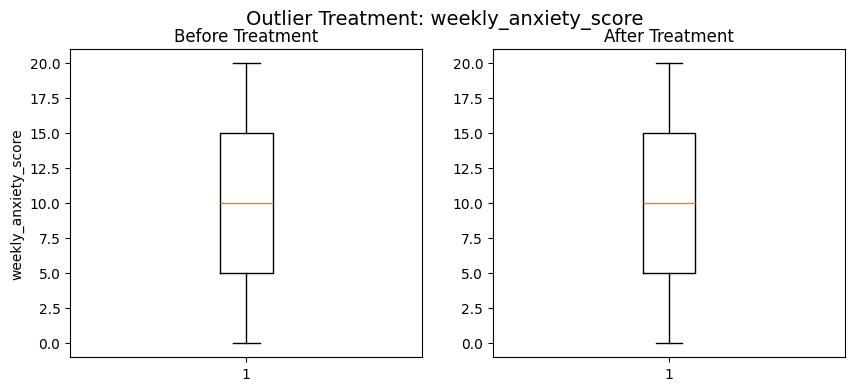

Outliers detected per column:
{'age': 0, 'daily_screen_time_hours': 18, 'phone_usage_hours': 6, 'laptop_usage_hours': 7, 'tablet_usage_hours': 4, 'tv_usage_hours': 6, 'social_media_hours': 9, 'work_related_hours': 5, 'entertainment_hours': 5, 'gaming_hours': 9, 'sleep_duration_hours': 11, 'sleep_quality': 0, 'mood_rating': 0, 'stress_level': 0, 'physical_activity_hours_per_week': 6, 'mental_health_score': 0, 'uses_wellness_apps': 0, 'eats_healthy': 0, 'caffeine_intake_mg_per_day': 14, 'weekly_anxiety_score': 0, 'weekly_depression_score': 0, 'mindfulness_minutes_per_day': 6, 'gender_Male': 0, 'gender_Other': 183, 'location_type_Suburban': 0, 'location_type_Urban': 0}

Before Treatment:
                age  daily_screen_time_hours  phone_usage_hours  \
count  2000.000000              2000.000000        2000.000000   
mean     38.805500                 6.025600           3.023700   
std      14.929203                 1.974123           1.449399   
min      13.000000                 0.0000

In [30]:


df = pd.read_csv('processed_encoding.csv')
df.head(),df.shape,df.describe()

numeric_cols = df.select_dtypes(include=[np.number]).columns

def treat_outliers_iqr(data, cols):
    df_clean = data.copy()
    outlier_summary = {}

    for col in cols:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR


        outliers = ((df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)).sum()
        outlier_summary[col] = int(outliers)


        df_clean[col] = np.where(df_clean[col] < lower_bound, lower_bound,
                          np.where(df_clean[col] > upper_bound, upper_bound, df_clean[col]))

        if col in ["daily_screen_time_hours", "caffeine_intake_mg_per_day", "weekly_anxiety_score"]:
            fig, axes = plt.subplots(1, 2, figsize=(10, 4))
            fig.suptitle(f"Outlier Treatment: {col}", fontsize=14)

            axes[0].boxplot(data[col], vert=True)
            axes[0].set_title("Before Treatment")
            axes[0].set_ylabel(col)

            axes[1].boxplot(df_clean[col], vert=True)
            axes[1].set_title("After Treatment")

            plt.show()


    return df_clean, outlier_summary

df_clean, outlier_summary = treat_outliers_iqr(df, numeric_cols)

print("Outliers detected per column:")
print(outlier_summary)

print("\nBefore Treatment:\n", df[numeric_cols].describe())
print("\nAfter Treatment:\n", df_clean[numeric_cols].describe())

df_clean.to_csv("processed_clean.csv", index=False)


# **Normalization / scaling**

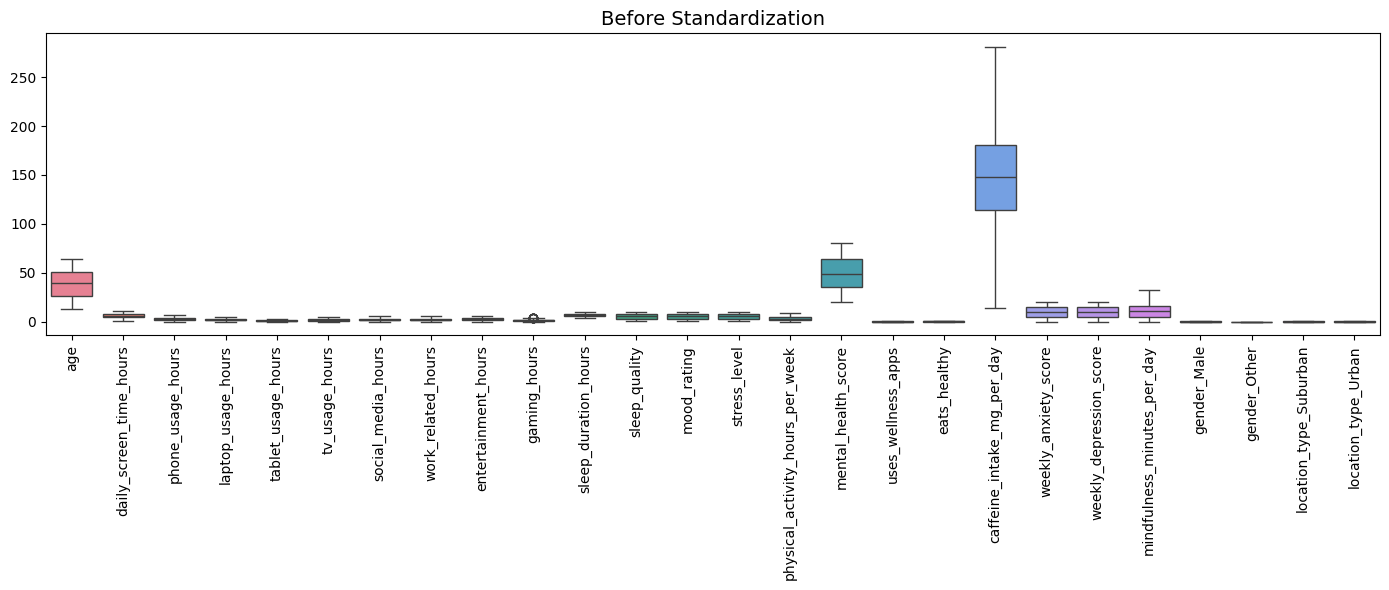

Scaled dataset preview:
        age  daily_screen_time_hours  phone_usage_hours  laptop_usage_hours  \
0  0.817026                -0.624735           0.261120           -0.702817   
1  1.688020                -1.083588           0.330300           -0.199979   
2  0.147031                 2.281335          -0.638221            0.604562   
3 -0.790963                 1.414613          -2.091003           -2.010196   
4  1.085024                -0.063914          -0.914942           -0.903952   

   tablet_usage_hours  tv_usage_hours  social_media_hours  work_related_hours  \
0            1.228251        0.101537            1.826081           -0.008881   
1           -0.194041        0.519815            0.586319            0.977913   
2           -0.600410        0.728955            0.851982            0.708787   
3           -0.600410        1.042663            1.117645           -0.367715   
4            1.025066        0.101537           -0.830552            1.426456   

   entertainme

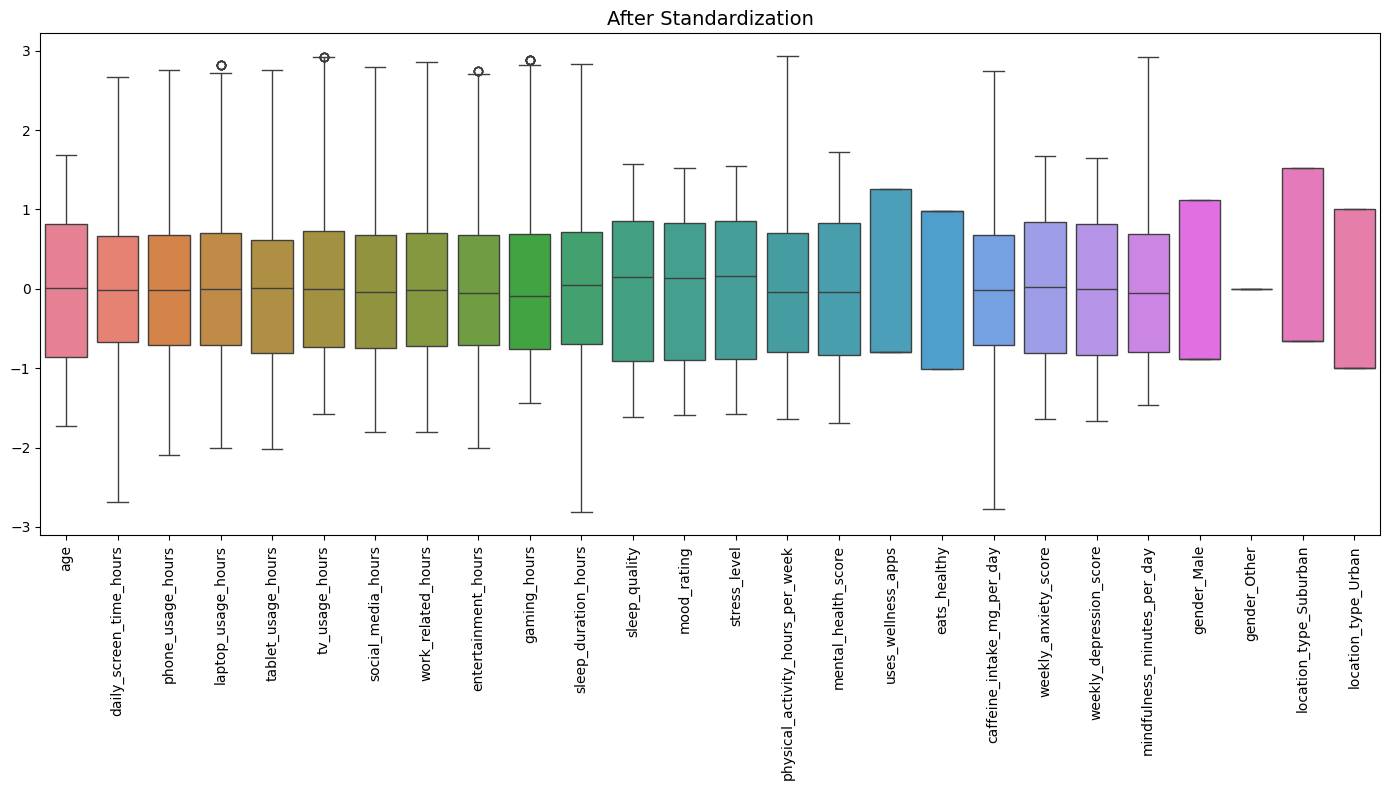

In [31]:


# Load CSV into DataFrame
df = pd.read_csv("processed_clean.csv")

# Drop 'user_id' if it exists
if 'user_id' in df.columns:
    df = df.drop(columns=['user_id'])

#  Boxplot BEFORE Standardization
continuous_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

plt.figure(figsize=(14,6))
sns.boxplot(data=df[continuous_cols])
plt.title("Before Standardization", fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Standardization
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[continuous_cols] = scaler.fit_transform(df[continuous_cols])

print("Scaled dataset preview:")
print(df_scaled.head())

#  Boxplot AFTER Standardization
plt.figure(figsize=(14,8))
sns.boxplot(data=df_scaled[continuous_cols])
plt.title("After Standardization", fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

df_scaled.to_csv("processed_Normalized.csv", index=False)

# **Feature Selection**

In [32]:

# Load dataset

df = pd.read_csv("processed_Normalized.csv")
print("Dataset loaded .. shape:", df.shape)

TARGET = "stress_level"

device_cols = ['phone_usage_hours','tablet_usage_hours',
               'laptop_usage_hours','tv_usage_hours']
device_cols = [c for c in device_cols if c in df.columns]

if device_cols:
    df['total_screen_hours'] = df[device_cols].sum(axis=1)
else:
    df['total_screen_hours'] = df['daily_screen_time_hours']

if 'sleep_duration_hours' in df.columns:
    df['screen_per_sleep'] = df['total_screen_hours'] / df['sleep_duration_hours'].replace(0,np.nan)
    df['sleep_deficit'] = 8 - df['sleep_duration_hours']
    df['short_sleep'] = (df['sleep_duration_hours'] < 7).astype(int)

if 'social_media_hours' in df.columns:
    df['digital_ratio'] = df['social_media_hours'] / df['total_screen_hours'].replace(0,np.nan)

if {'work_related_hours','entertainment_hours'}.issubset(df.columns):
    df['work_leisure_ratio'] = df['work_related_hours'] / df['entertainment_hours'].replace(0,np.nan)

if {'caffeine_intake_mg_per_day','sleep_duration_hours'}.issubset(df.columns):
    df['caffeine_per_sleep_hour'] = df['caffeine_intake_mg_per_day'] / df['sleep_duration_hours'].replace(0,np.nan)

if 'total_screen_hours' in df.columns:
    df['high_screen'] = (df['total_screen_hours'] > df['total_screen_hours'].median()).astype(int)

new_features = [c for c in df.columns if c not in pd.read_csv("processed_Normalized.csv").columns]
print(" New Features Created:", new_features)



Dataset loaded .. shape: (2000, 26)
 New Features Created: ['total_screen_hours', 'screen_per_sleep', 'sleep_deficit', 'short_sleep', 'digital_ratio', 'work_leisure_ratio', 'caffeine_per_sleep_hour', 'high_screen']


Target variable 'stress_level' discretized into categories for Mutual Information calculation.


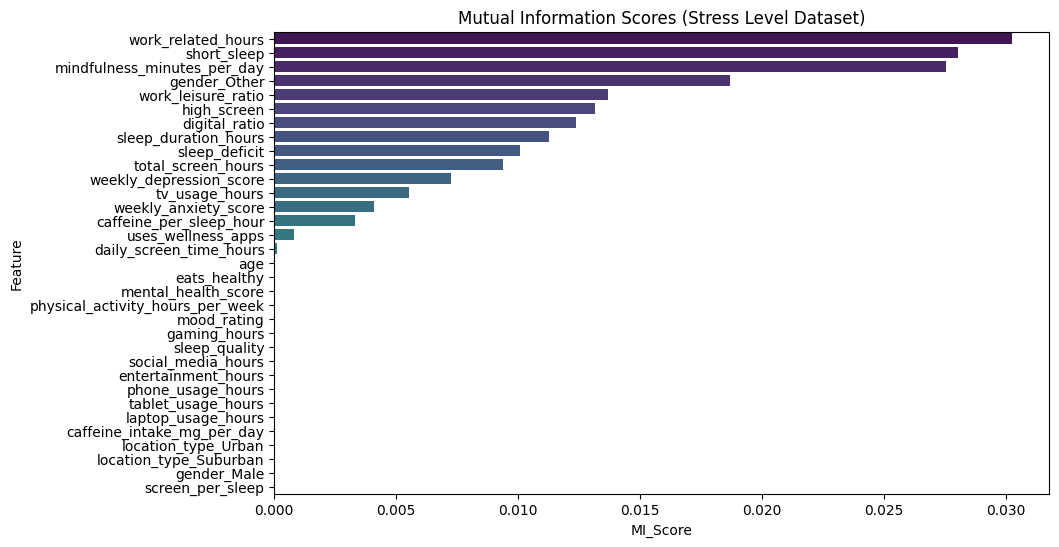

Final Selected Features (Top 10 by MI): ['work_related_hours', 'short_sleep', 'mindfulness_minutes_per_day', 'gender_Other', 'work_leisure_ratio', 'high_screen', 'digital_ratio', 'sleep_duration_hours', 'sleep_deficit', 'total_screen_hours']


In [23]:


# Assuming df and TARGET are already defined in the previous cell
# If not, you would need to load the data and define TARGET here.
# Example:
# df = pd.read_csv("processed_Normalized.csv")
# TARGET = "stress_level"

X = df.drop(columns=[TARGET], errors="ignore").select_dtypes(include='number')
y = df[TARGET] if TARGET in df.columns else None

# Discretize the target variable if it exists
if y is not None:
    try:
        # Bin the continuous target variable into discrete categories
        # Using pd.cut to bin based on quantiles (e.g., 4 bins)
        y_discrete = pd.cut(y, bins=10, labels=False, duplicates='drop')
        print(f"Target variable '{TARGET}' discretized into categories for Mutual Information calculation.")

        # Calculate Mutual Information scores
        mi_scores = mutual_info_classif(X, y_discrete, discrete_features="auto", random_state=42)
        mi_df = pd.DataFrame({"Feature": X.columns, "MI_Score": mi_scores})
        mi_df = mi_df.sort_values(by="MI_Score", ascending=False)

        plt.figure(figsize=(10,6))
        sns.barplot(x="MI_Score", y="Feature", data=mi_df, hue="Feature",dodge=False, palette="viridis",legend=False)
        plt.title("Mutual Information Scores (Stress Level Dataset)")
        plt.show()

        # Select top features
        selected_features = mi_df["Feature"].tolist()[:10]
        print("Final Selected Features (Top 10 by MI):", selected_features)

    except Exception as e:
        print(f"An error occurred during Mutual Information calculation: {e}")
        print("Skipping Mutual Information calculation and plotting.")
else:
    print(f"Target variable '{TARGET}' not found or could not be processed. Skipping Mutual Information calculation and plotting.")

# **PCA - Dimensionality reduction**

First 5 rows of PCA Components:
   PCA_Component_1  PCA_Component_2  PCA_Component_3  PCA_Component_4  \
0         1.868564         0.025057         0.990045        -0.094805   
1         1.065525        -0.752164         0.625813         2.388186   
2         8.802052         0.380436         0.201489        -0.643582   
3        -0.489824         0.495719        -3.628959         1.760911   
4         0.988739        -1.004872        -0.748738        -0.994216   

   PCA_Component_5  PCA_Component_6  PCA_Component_7  PCA_Component_8  \
0        -0.683625         0.569762         0.308188     0.000000e+00   
1         0.214277         1.114923         0.419223    -3.286260e-14   
2         0.109177         0.844797         0.467185     5.329071e-15   
3        -0.894331         0.363211         0.251391    -2.309264e-14   
4        -0.149878         2.065665        -0.337186     1.421085e-14   

   PCA_Component_9  PCA_Component_10  
0    -4.996004e-16     -1.379452e-14  
1    -1.7763

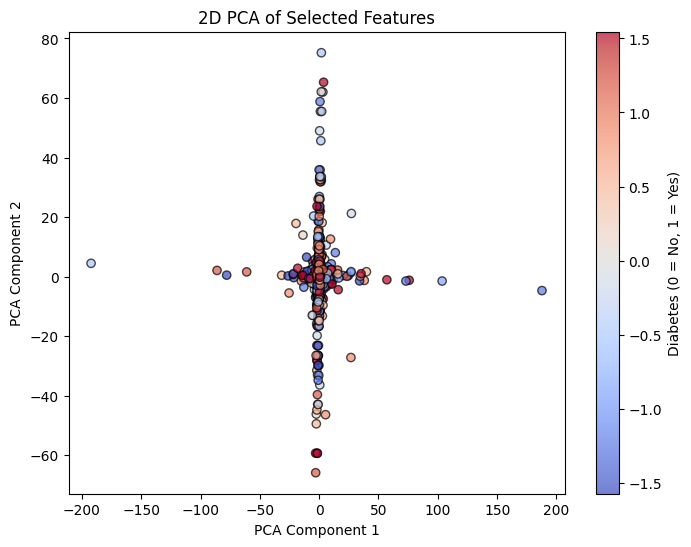

In [33]:
# X and y from scaled dataset
X = df[selected_features].copy()
y = df[TARGET]   # target variable

# Apply PCA
pca = PCA(n_components=min(10, X.shape[1]))
X_pca = pca.fit_transform(X)

# Create PCA DataFrame
pca_df = pd.DataFrame(X_pca, columns=[f'PCA_Component_{i+1}' for i in range(X_pca.shape[1])])
print("First 5 rows of PCA Components:")
print(pca_df.head())

# Explained variance
explained_variance = pca.explained_variance_ratio_
print("\nExplained Variance Ratio per component:", explained_variance)
print("Total Variance Explained:", explained_variance.sum())

# 2D PCA visualization (first 2 components)
plt.figure(figsize=(8,6))
scatter = plt.scatter(
    X_pca[:,0], X_pca[:,1],
    c=y, cmap='coolwarm', edgecolors='k', alpha=0.7
)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('2D PCA of Selected Features')
plt.colorbar(scatter, label="Diabetes (0 = No, 1 = Yes)")
plt.show()

# **Output**

In [34]:
df_final =  df[selected_features + [TARGET]].copy()

output_file = 'processed_data.csv'

df_final.to_csv(output_file, index=False)

print(f"CSV file saved successfully as '{output_file}'")

CSV file saved successfully as 'processed_data.csv'
